In [33]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import seaborn as sns

sys.path.insert(1, '/Users/nickkeesey/Desktop/learning-dynamics-behavior/src/utils')
import behavior_utils as bu
import array_utils as au


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:

trial_file = '/Users/nickkeesey/Desktop/learning-dynamics-behavior/data/foraging_trials_bonsai.csv'
trial_df = pd.read_csv(trial_file)

In [35]:
session_file = '/Users/nickkeesey/Desktop/learning-dynamics-behavior/data/filtered_data_20241107.csv'
session_df = pd.read_csv(session_file)


In [36]:
session_df.columns.to_list()

['subject_id',
 'session_date',
 'nwb_suffix',
 'session',
 'rig',
 'user_name',
 'curriculum_name',
 'curriculum_version',
 'current_stage_actual',
 'task',
 'notes',
 'experiment_description',
 'session_start_time',
 'session_end_time',
 'session_run_time_in_min',
 'water_in_session_foraging',
 'water_in_session_manual',
 'water_in_session_total',
 'water_after_session',
 'water_day_total',
 'base_weight',
 'target_weight',
 'target_weight_ratio',
 'weight_after',
 'laser_1_calibration_power',
 'laser_2_calibration_power',
 'laser_1_target_areas',
 'laser_2_target_areas',
 'commit_ID',
 'repo_url',
 'current_branch',
 'weight_after_ratio',
 'p_reward_sum_mean',
 'p_reward_sum_std',
 'p_reward_sum_median',
 'p_reward_contrast_mean',
 'p_reware_contrast_median',
 'effective_block_length_mean',
 'effective_block_length_std',
 'effective_block_length_median',
 'effective_block_length_min',
 'effective_block_length_max',
 'duration_gocue_stop_mean',
 'duration_gocue_stop_std',
 'duration_

In [37]:
# Filtering

session_df_filt = session_df.loc[:, ['subject_id', 'session_date', 
                                     'session', 'curriculum_name', 'curriculum_version', 
                                     'current_stage_actual', 'task', 'p_reward_sum_mean', 
                                     'effective_block_length_mean','autowater_collected', 'autowater_ignored',
                                     'ignore_rate', 'reward_rate', 'finished_rate', 'double_dipping_rate_finished_trials',
                                     'double_dipping_rate_finished_reward_trials',
                                     'double_dipping_rate_finished_noreward_trials',
                                     'lick_consistency_mean_finished_trials',
                                     'lick_consistency_mean_finished_reward_trials',
                                     'lick_consistency_mean_finished_noreward_trials',
                                     'foraging_performance', 'foraging_eff', 'early_lick_rate', 
                                     'invalid_lick_ratio', 'double_dipping_rate_finished_trials', 
                                     'lick_consistency_mean_finished_trials']]

session_df_filt.columns.to_list()


['subject_id',
 'session_date',
 'session',
 'curriculum_name',
 'curriculum_version',
 'current_stage_actual',
 'task',
 'p_reward_sum_mean',
 'effective_block_length_mean',
 'autowater_collected',
 'autowater_ignored',
 'ignore_rate',
 'reward_rate',
 'finished_rate',
 'double_dipping_rate_finished_trials',
 'double_dipping_rate_finished_reward_trials',
 'double_dipping_rate_finished_noreward_trials',
 'lick_consistency_mean_finished_trials',
 'lick_consistency_mean_finished_reward_trials',
 'lick_consistency_mean_finished_noreward_trials',
 'foraging_performance',
 'foraging_eff',
 'early_lick_rate',
 'invalid_lick_ratio',
 'double_dipping_rate_finished_trials',
 'lick_consistency_mean_finished_trials']

In [ ]:
# Feature notes

# finished rate -- upwards increase at stage level, plateu at session 20

# ignore rate -- downwards decrease at stage level, plateu at session 20

# reward rate -- V shape (STAGE_3) at stage level, sig. decrease until session 10 then slow decrease

# median reaction time -- normal (but only until STAGE_FINAL) decrease at stage level, ONLY until session ~7

# mean reaction time -- normal (but only until STAGE_FINAL) decrease at stage level, ONLY until session ~7

# early lick rate -- upwards V shape (STAGE_3) at stage level, plateu at session 20

# invalid lick ratio -- slight increase at stage level (but only until STAGE_FINAL), ONLY until session ~7

# double dipping rate (finished trials) -- large decrease at until STAGE_2, then flat,  plateu at session 20

# double dipping rate rewarded (finished trials) -- decrease at stage level,  plateu at session 10

# double dipping rate non-rewarded (finished trials) -- decrease at stage level but only until STAGE_2,  plateu at session 10

# lick consistency mean (finished trials) -- increase at stage level, plateu at session 20

# lick consistency mean (finished reward trials) -- increase at stage level, plateu at session 10

# lick consistency mean (finished non-rewarded trials) -- increase until STAGE 3, then slight decrease, plateu at session 10



In [290]:
# Protyping metrics

test_session_df = session_df.copy()

# Prototype metric 1: 1 / (early lick rate + double dipping rate)
test_session_df['prototype_metric_1'] = np.where(
    (test_session_df['early_lick_rate'] + test_session_df['double_dipping_rate_finished_trials']) != 0,
    (1/ (test_session_df['early_lick_rate'] + test_session_df['double_dipping_rate_finished_trials'])),
    np.inf
)

# Prototype metric 2: finished rate / (early lick rate + double dipping rate)
test_session_df['prototype_metric_2'] = np.where(
    (test_session_df['early_lick_rate'] + test_session_df['double_dipping_rate_finished_trials'] + test_session_df['finished_rate']) != 0,
    (test_session_df['finished_rate'] / (test_session_df['early_lick_rate'] + test_session_df['double_dipping_rate_finished_trials'])),
    np.inf
)

# Prototype metric 3: finished rate / (double dipping rate + reaction time*0.0001)
test_session_df['prototype_metric_3'] = np.where(
    (test_session_df['finished_rate'] + test_session_df['double_dipping_rate_finished_trials'] + test_session_df['reaction_time_mean']) != 0,
    ((test_session_df['finished_rate'] / test_session_df['double_dipping_rate_finished_trials'] + (test_session_df['reaction_time_mean']*0.0001))),
    np.inf
)

# Prototype metric 4: finished rate / (finished rate + double dipping rate + reaction time)
test_session_df['prototype_metric_4'] = np.where(
    (test_session_df['finished_rate'] + test_session_df['double_dipping_rate_finished_trials'] + test_session_df['reaction_time_mean']) != 0,
    (test_session_df['finished_rate'] / (test_session_df['finished_rate'] + test_session_df['double_dipping_rate_finished_trials'] + test_session_df['reaction_time_mean'])),
    np.inf
)

# Prototype metric 5: finished rate * lick consistency / (1 + early_lick_rate + double_dipping_rate)
test_session_df['prototype_metric_5'] = (
    (2 * test_session_df['finished_rate'] * test_session_df['reward_rate'] * 
     test_session_df['lick_consistency_mean_finished_trials']) /
    (1 + test_session_df['early_lick_rate'] + 
     2 * test_session_df['double_dipping_rate_finished_trials'] +
     test_session_df['invalid_lick_ratio'])
)

# Preprocessing 
#test_session_df = bu.filter_by_group_size(test_session_df, group_col='subject_id', max_rows=30)
test_session_df = bu.clean_dataframe(test_session_df, threshold=0.5, verbose=True)
test_session_df = bu.add_session_column(test_session_df)

# Define stage order
stage_order = ['STAGE_1', 'STAGE_2', 'STAGE_3', 'STAGE_FINAL', 'GRADUATED']
test_session_df['current_stage_actual'] = pd.Categorical(test_session_df['current_stage_actual'], categories=stage_order)

Removed 0 rows with more than 50.0% NaN values

Remaining NaN counts per column:
laser_1_calibration_power         8986
laser_2_calibration_power         8985
laser_1_target_areas              8966
laser_2_target_areas              8965
results_location                  7480
                                  ... 
logistic_Hattori2019_UnrC_amp        2
logistic_Hattori2019_UnrC_tau        2
logistic_Su2022_UnrC_tau             2
logistic_Miller2021_Reward_tau       1
logistic_Miller2021_Reward_amp       1
Length: 91, dtype: int64

Original DataFrame shape: (9083, 168)
Cleaned DataFrame shape: (9083, 168)


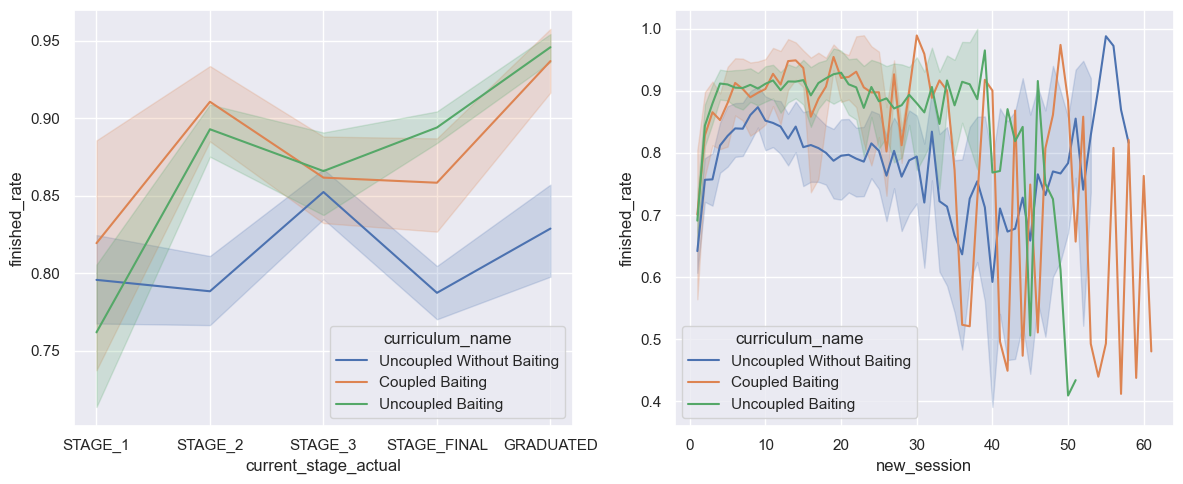

In [291]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot by stage
sns.lineplot(data=test_session_df, x='current_stage_actual', y='finished_rate', hue='curriculum_name', ax=ax1)

# Plot by session with curriculum
sns.lineplot(data=test_session_df, x='new_session', y='finished_rate', 
             hue='curriculum_name', ax=ax2)


plt.tight_layout()

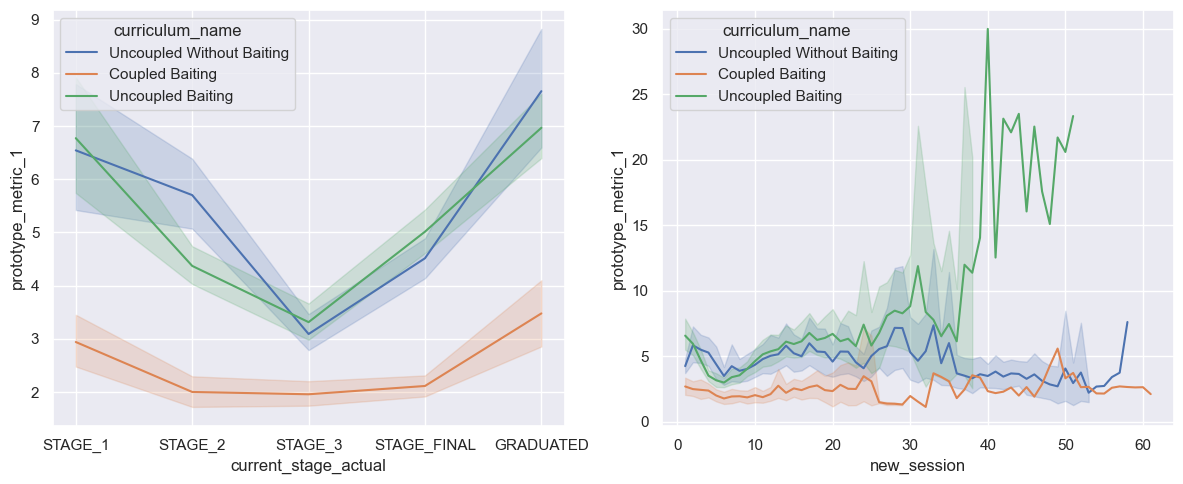

In [292]:
# Plot both metrics side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot by stage
sns.lineplot(data=test_session_df, x='current_stage_actual', y='prototype_metric_1', hue='curriculum_name', ax=ax1)

# Plot by session with curriculum
sns.lineplot(data=test_session_df, x='new_session', y='prototype_metric_1', 
             hue='curriculum_name', ax=ax2)


plt.tight_layout()

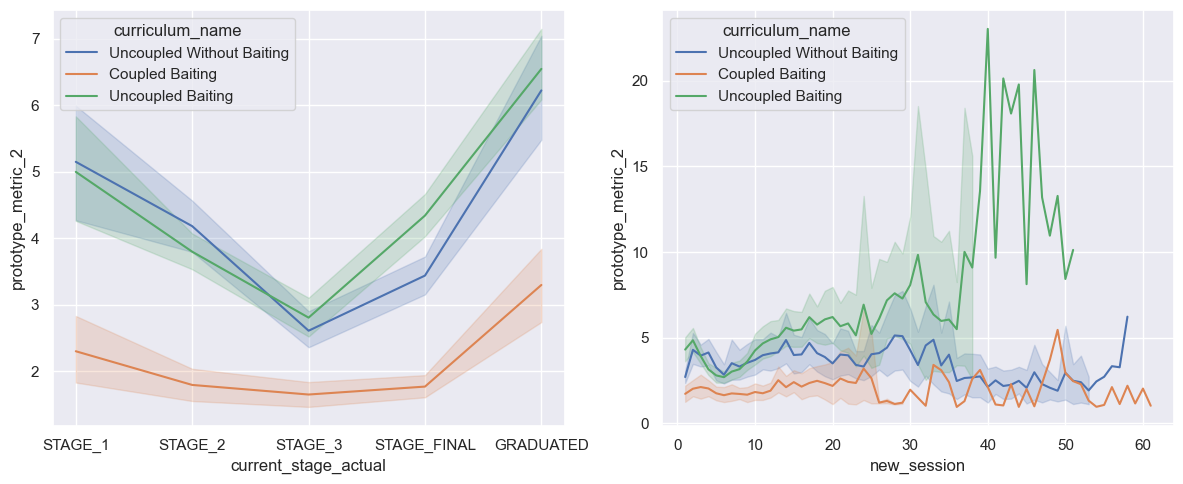

In [293]:
# Plot both metrics side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot by stage
sns.lineplot(data=test_session_df, x='current_stage_actual', y='prototype_metric_2', hue='curriculum_name', ax=ax1)

# Plot by session with curriculum
sns.lineplot(data=test_session_df, x='new_session', y='prototype_metric_2', 
             hue='curriculum_name', ax=ax2)


plt.tight_layout()

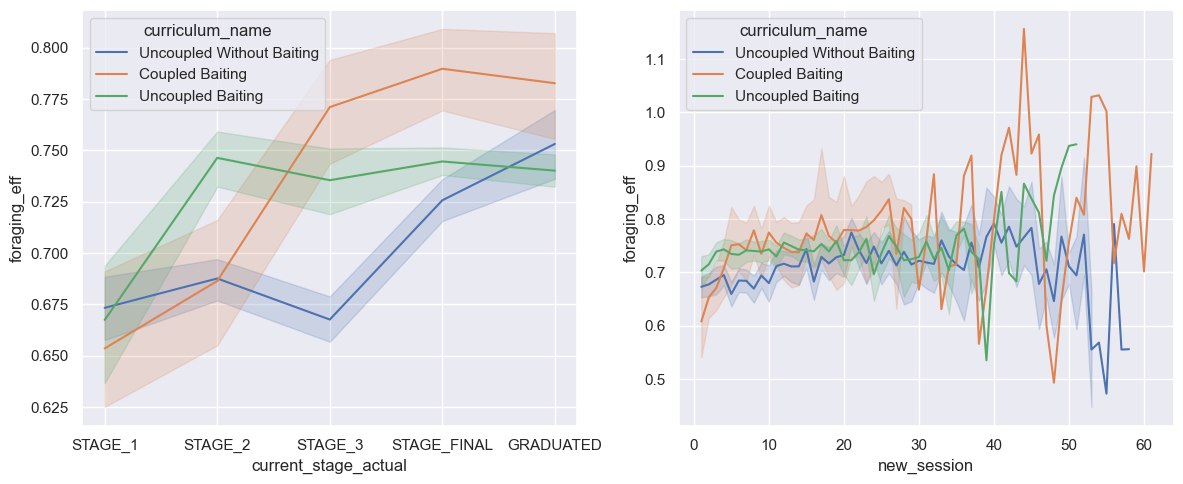

In [294]:
# Plot both metrics side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot by stage
sns.lineplot(data=test_session_df, x='current_stage_actual', y='foraging_eff', hue='curriculum_name', ax=ax1)

# Plot by session with curriculum
sns.lineplot(data=test_session_df, x='new_session', y='foraging_eff', 
             hue='curriculum_name', ax=ax2)


plt.tight_layout()

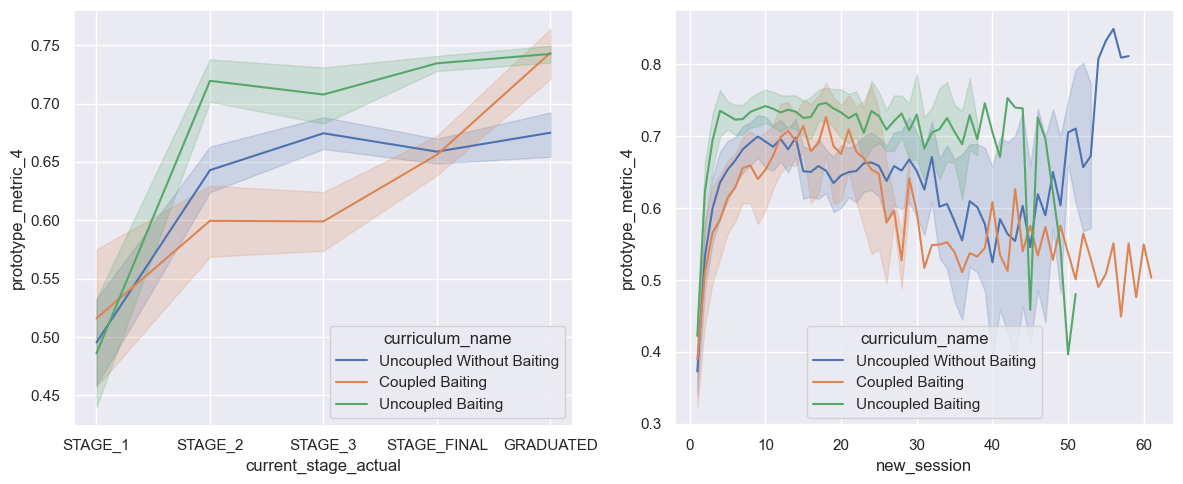

In [295]:
# Plot both metrics side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot by stage
sns.lineplot(data=test_session_df, x='current_stage_actual', y='prototype_metric_4', hue='curriculum_name', ax=ax1)

# Plot by session with curriculum
sns.lineplot(data=test_session_df, x='new_session', y='prototype_metric_4', 
             hue='curriculum_name', ax=ax2)


plt.tight_layout()

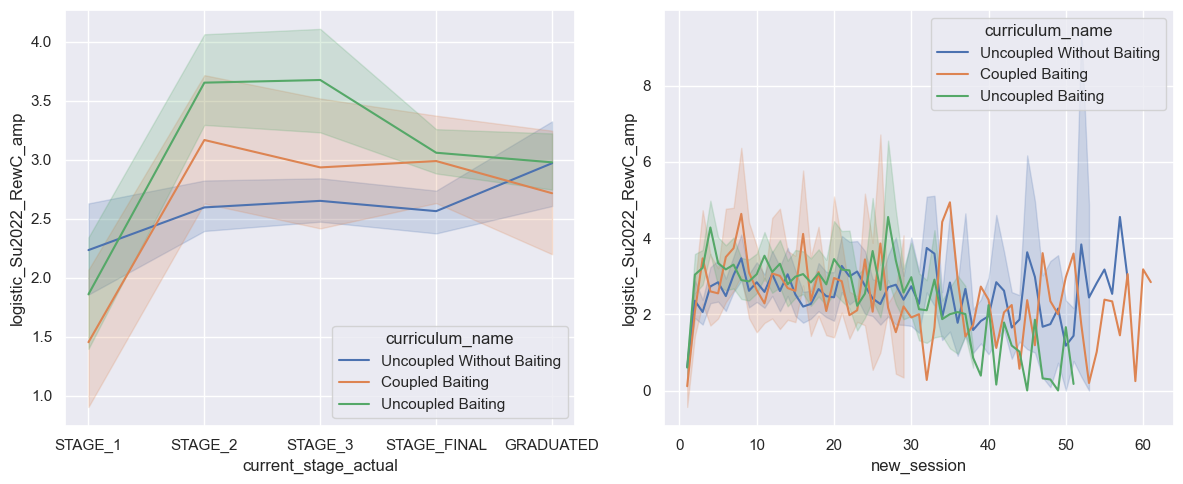

In [296]:
# Plot both metrics side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot by stage
sns.lineplot(data=test_session_df, x='current_stage_actual', y='logistic_Su2022_RewC_amp', hue='curriculum_name', ax=ax1)

# Plot by session with curriculum
sns.lineplot(data=test_session_df, x='new_session', y='logistic_Su2022_RewC_amp', 
             hue='curriculum_name', ax=ax2)


plt.tight_layout()

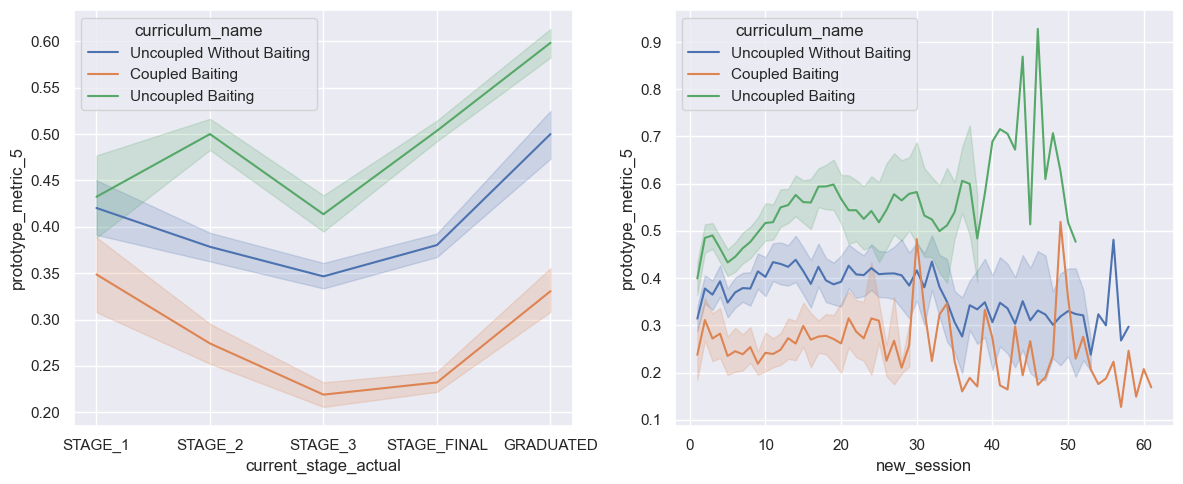

In [297]:
# Plot both metrics side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot by stage
sns.lineplot(data=test_session_df, x='current_stage_actual', y='prototype_metric_5', hue='curriculum_name', ax=ax1)

# Plot by session with curriculum
sns.lineplot(data=test_session_df, x='new_session', y='prototype_metric_5', 
             hue='curriculum_name', ax=ax2)

plt.tight_layout()

In [304]:
# Array utils

arrays = au.create_arrays(test_session_df, stage_col='current_stage_actual', subject_col='subject_id', metric='prototype_metric_4', task_col='curriculum_name')
au.remove_outliers_n(arrays, n=40)
au.summary_statistics(arrays)

No data found for nan and nan
No data found for nan and Uncoupled Without Baiting
No data found for nan and Coupled Baiting
No data found for nan and Uncoupled Baiting
No data found for STAGE_3 and nan
No data found for STAGE_FINAL and nan
No data found for STAGE_2 and nan
No data found for STAGE_1 and nan
No data found for GRADUATED and nan


,Stage,Task,Array Shape,Mean,Std Dev,Min,Max,Outliers
0,STAGE_3,Uncoupled Without Baiting,"(397, 22)",0.798489,2.432918,0,22,2
1,STAGE_3,Coupled Baiting,"(397, 23)",0.158690,1.302006,0,23,16
2,STAGE_3,Uncoupled Baiting,"(397, 11)",0.294710,0.955587,0,11,10
3,STAGE_FINAL,Uncoupled Without Baiting,"(397, 33)",1.226700,4.289756,0,33,5
4,STAGE_FINAL,Coupled Baiting,"(397, 23)",0.317380,1.938611,0,23,15
5,STAGE_FINAL,Uncoupled Baiting,"(397, 34)",1.546599,3.924472,0,34,1
6,STAGE_2,Uncoupled Without Baiting,"(397, 14)",0.670025,1.712139,0,11,1
7,STAGE_2,Coupled Baiting,"(397, 11)",0.120907,0.869576,0,11,16
8,STAGE_2,Uncoupled Baiting,"(397, 5)",0.418136,0.928949,0,5,0
9,STAGE_1,Uncoupled Without Baiting,"(397, 9)",0.221662,0.699935,0,5,0


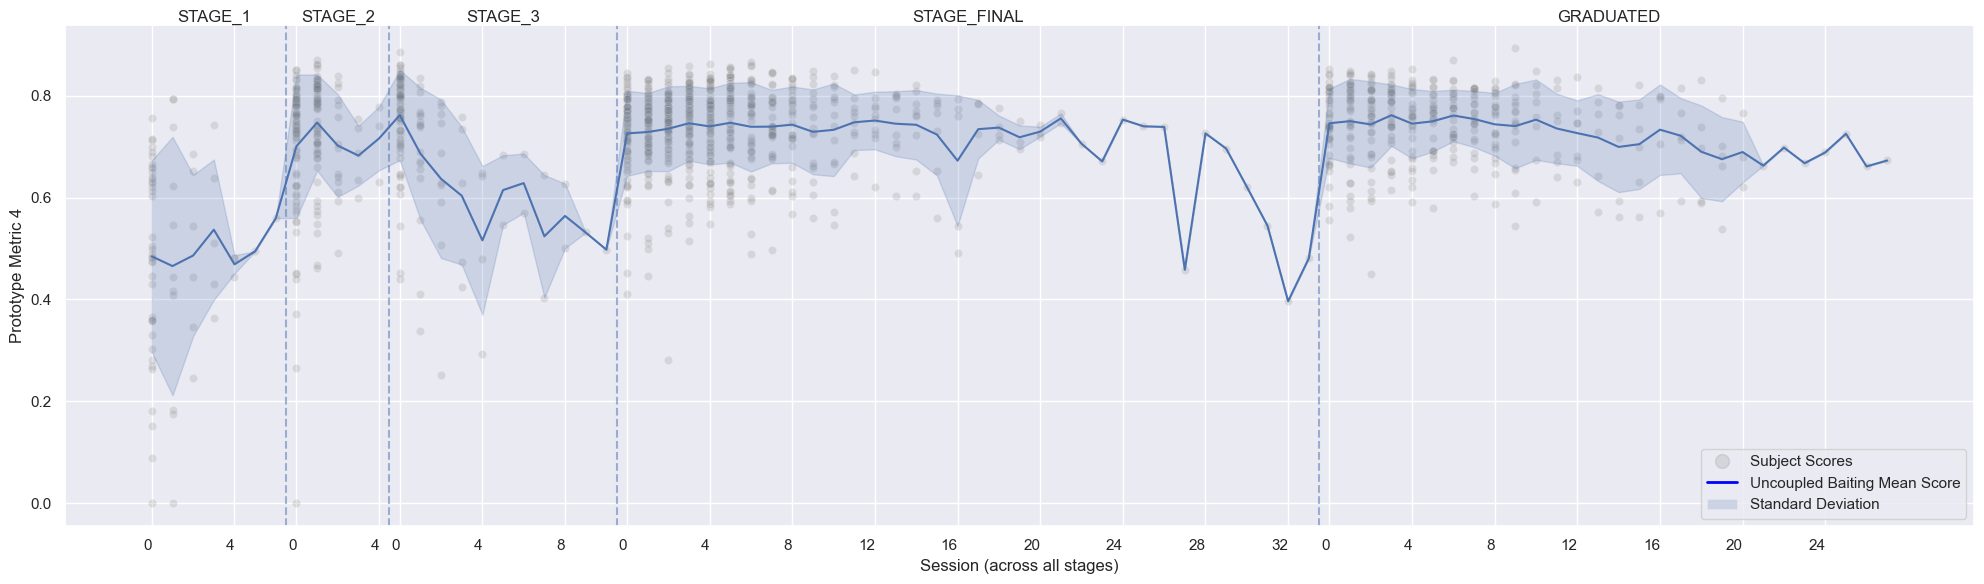


Statistics for Task: Uncoupled Baiting:

STAGE_1:
Number of Sessions: 7
Mean Prototype Metric 4: 0.50
Standard deviation: 0.04
Min efficiency: 0.47
Max efficiency: 0.56

STAGE_2:
Number of Sessions: 5
Mean Prototype Metric 4: 0.71
Standard deviation: 0.02
Min efficiency: 0.68
Max efficiency: 0.75

STAGE_3:
Number of Sessions: 11
Mean Prototype Metric 4: 0.60
Standard deviation: 0.08
Min efficiency: 0.50
Max efficiency: 0.76

STAGE_FINAL:
Number of Sessions: 34
Mean Prototype Metric 4: 0.70
Standard deviation: 0.09
Min efficiency: 0.40
Max efficiency: 0.76

GRADUATED:
Number of Sessions: 28
Mean Prototype Metric 4: 0.72
Standard deviation: 0.03
Min efficiency: 0.66
Max efficiency: 0.76


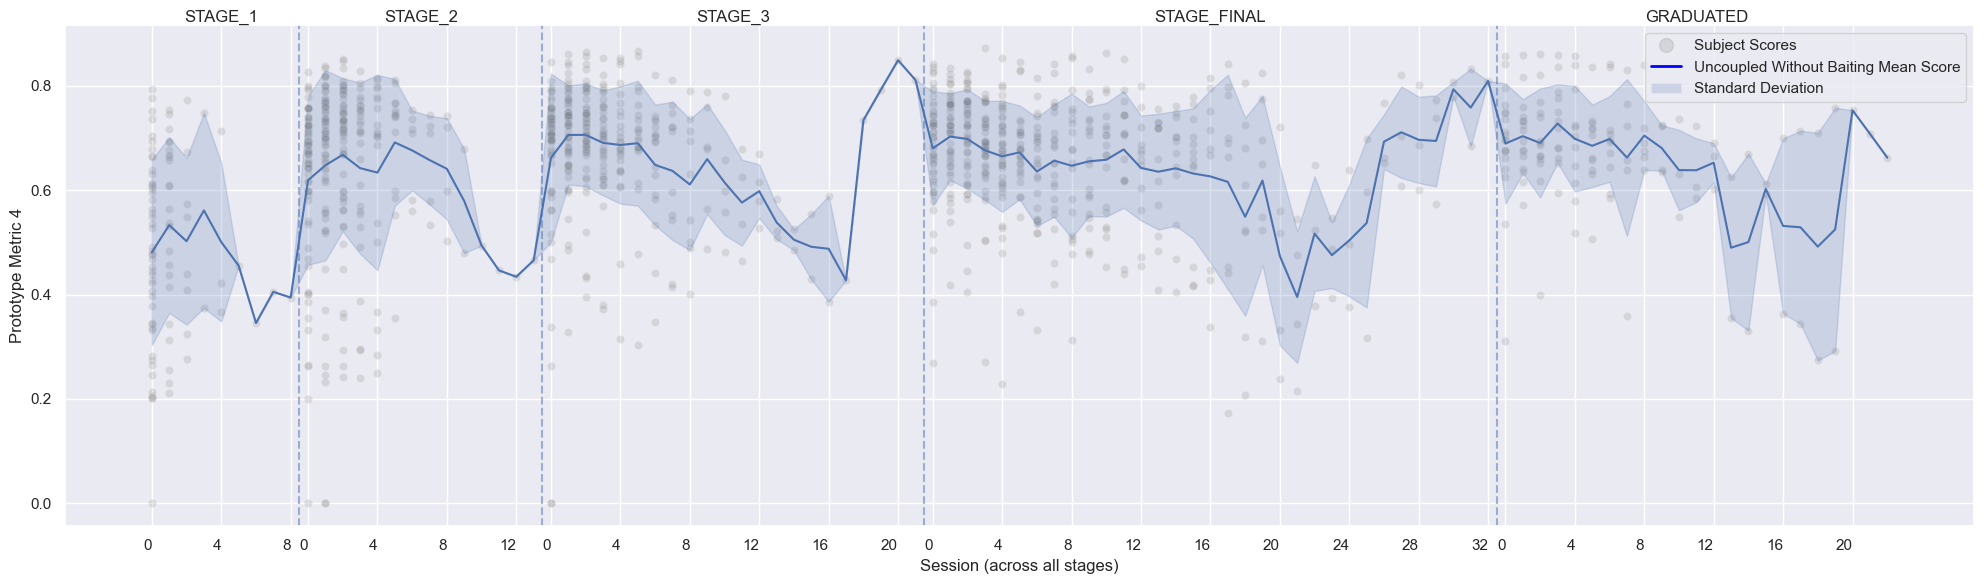


Statistics for Task: Uncoupled Without Baiting:

STAGE_1:
Number of Sessions: 9
Mean Prototype Metric 4: 0.46
Standard deviation: 0.07
Min efficiency: 0.35
Max efficiency: 0.56

STAGE_2:
Number of Sessions: 14
Mean Prototype Metric 4: 0.59
Standard deviation: 0.09
Min efficiency: 0.43
Max efficiency: 0.69

STAGE_3:
Number of Sessions: 22
Mean Prototype Metric 4: 0.64
Standard deviation: 0.11
Min efficiency: 0.43
Max efficiency: 0.85

STAGE_FINAL:
Number of Sessions: 33
Mean Prototype Metric 4: 0.64
Standard deviation: 0.09
Min efficiency: 0.40
Max efficiency: 0.81

GRADUATED:
Number of Sessions: 23
Mean Prototype Metric 4: 0.64
Standard deviation: 0.08
Min efficiency: 0.49
Max efficiency: 0.75


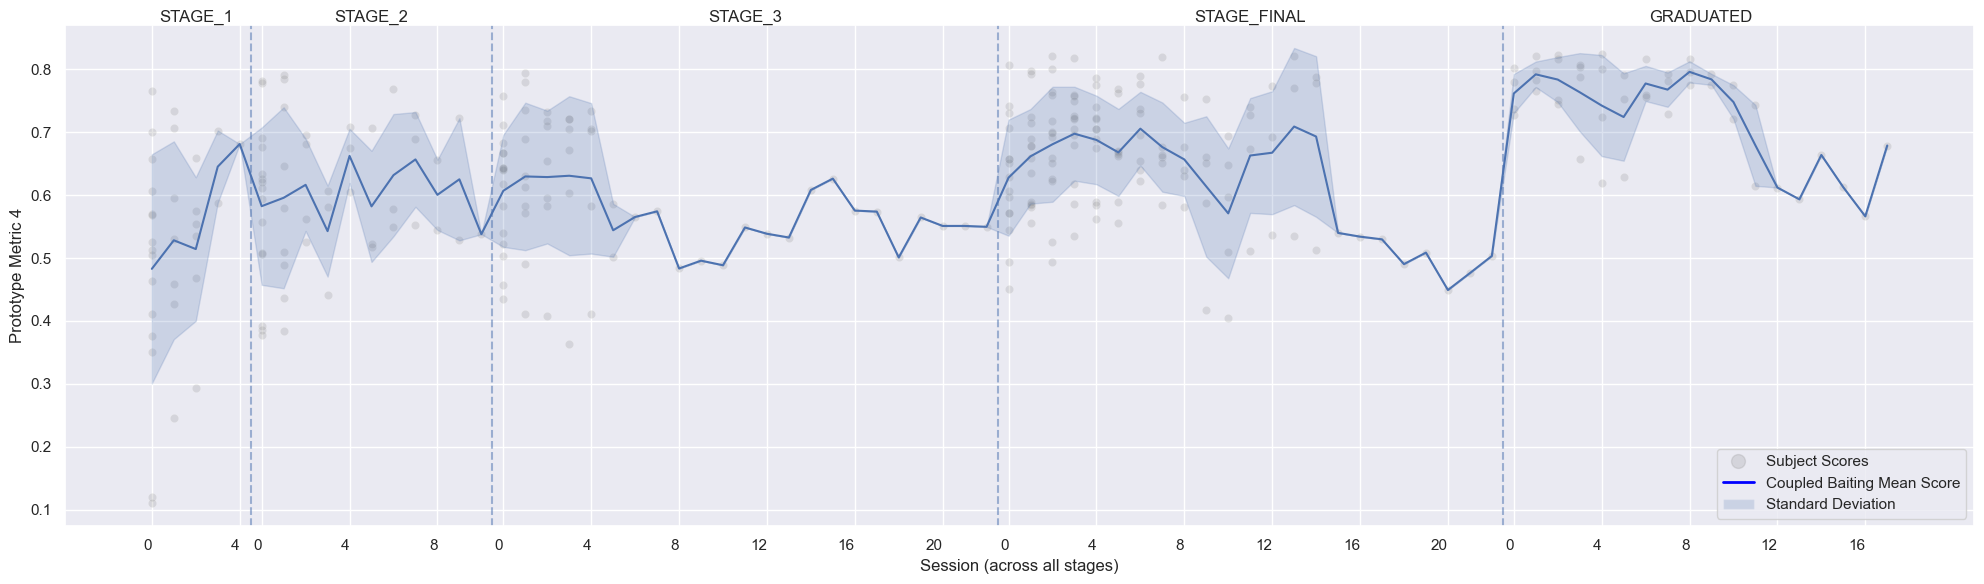


Statistics for Task: Coupled Baiting:

STAGE_1:
Number of Sessions: 5
Mean Prototype Metric 4: 0.57
Standard deviation: 0.09
Min efficiency: 0.48
Max efficiency: 0.68

STAGE_2:
Number of Sessions: 11
Mean Prototype Metric 4: 0.60
Standard deviation: 0.04
Min efficiency: 0.54
Max efficiency: 0.66

STAGE_3:
Number of Sessions: 23
Mean Prototype Metric 4: 0.56
Standard deviation: 0.05
Min efficiency: 0.48
Max efficiency: 0.63

STAGE_FINAL:
Number of Sessions: 23
Mean Prototype Metric 4: 0.61
Standard deviation: 0.09
Min efficiency: 0.45
Max efficiency: 0.71

GRADUATED:
Number of Sessions: 18
Mean Prototype Metric 4: 0.71
Standard deviation: 0.08
Min efficiency: 0.57
Max efficiency: 0.80


In [305]:
au.plot_metric(arrays, ylabel='Prototype Metric 4')